In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as plt_ticker
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
# import cv2 
from PIL import Image
# from scipy.misc import electrocardiogram
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import heapq
import tkinter as tk
# import seaborn as sns

##### onedrive path

## Math tool

In [2]:
import FFT as FFTfunc
import simulateLIPSS as LIPSS

In [3]:
def noice(row, col, randomRange):
    '''
    產生一個 row * col 的隨機數陣列，每個元素的值在 -randomRange ~ randomRange 之間
    '''
    # return (1/A)*np.random.randint(-A*randomRange, A*randomRange)
    return np.random.rand(row, col) * 2*randomRange - randomRange

def simulateArray(N, simulateRange):
    '''
    simulate an array. 
    array range:  2*simulateRange * 2*simulateRange
    array size : N * N
    
    並且以 r 替換 x,y。
    '''
    N = 1000
    simulateRange = 100
    x = np.linspace(-simulateRange, simulateRange, N)
    y = np.linspace(-simulateRange, simulateRange, N)
    XX, YY = np.meshgrid(x, y)
    r = np.sqrt(XX**2 + YY**2)
    return x, r, N, simulateRange

def findSecondPeak(data, second=None):
    
    # 使用 scipy.signal.find_peaks 找到所有 peak 的位置
    peak_pos, _ = find_peaks(data)

    # 將 peak 的值儲存在一個 list 中
    peak_values = data[peak_pos]

    # 使用 heapq.nlargest 找到 list 中第二大的值
    second_largest = heapq.nlargest(2, peak_values)[-1]

    # 找到第二大的值所對應的位置
    second_peak_pos = peak_pos[np.where(peak_values == second_largest)[0][0]]

    # print(f"第二高 peak 的位置：{second_peak_pos}")
    # print(f"第二高 peak 的值：{second_largest}")

    if second is not None:
        return second_largest
    else:
        return heapq.nlargest(4, peak_values)[-1] # 第四高的 peak
    

def findBackage(array):
    
    hist, bins = np.histogram(array, bins=30)  
    max_idx    = np.argmax(hist)
    return bins[max_idx]

def gauss(x,μ,σ,A):
    return A * np.exp(-(x-μ)**2/2/σ**2)

In [4]:
def plt3Dfunc(X, Y, Z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(X, Y, Z, cmap=plt.cm.coolwarm, alpha=0.5, antialiased=False)
    # Tweak the limits and add latex math labels.
    # ax.set_xlabel(r'$\phi_\mathrm{real}$')
    # ax.set_ylabel(r'$\phi_\mathrm{im}$')
    ax.set_zlabel(r'$V(\phi)$')
    plt.savefig("3d_ball_polar1.jpg",dpi=120)
    plt.show()

def F(r):
    E_0 = -0.2e-3 # mJ
    ω_0 = 20e-6   # um
    return 2**2 * E_0 * (r**2 / np.pi * ω_0**4 ) * np.exp(-2 * r**2 / ω_0**2)

def donetElectric(x, y, E_0, ω_0):
    r = np.sqrt(x**2 + y**2)
    first  = E_0 * (r**2 / np.pi * ω_0**4 )
    second = np.exp(-2 * r**2 / ω_0**2)
    return 2*2 * first * second

def plt3D_donet():

    # Create the mesh in polar coordinates and compute corresponding Z.
    r = np.linspace(0, 5e-5, 100)
    p = np.linspace(0, 2*np.pi, 100)
    R, P = np.meshgrid(r, p)
    Z = -F(R)
    X, Y = R*np.cos(P), R*np.sin(P)
    plt3Dfunc(X, Y, Z)
    
    def plt_test(plt_range):
        x = np.linspace(-plt_range*1e-6, plt_range*1e-6, 1000)
        XX, YY = np.meshgrid(x, x)
        ZZ = donetElectric(XX, YY, -0.2e-3, 20e-6)

        fig = plt.figure(figsize=(12,4), dpi=70)
        fig = plt.figure(figsize=(5 ,5), dpi=50)
        ax1 = fig.add_subplot(111)
        im = ax1.imshow(ZZ, cmap='gray')
        cbar = plt.colorbar(im, ax=ax1)

    # plt_test(40)
    
    def creatDonet(plt_range):
        x = np.linspace(-plt_range*1e-6, plt_range*1e-6, 100)
        XX, YY = np.meshgrid(x, x)
        Z = donetElectric(XX, YY, -0.2e-3, 20e-6)
        
#         # 利用 curve_fit 拟合数据
#         popt, pcov = curve_fit(donetElectric, (x, x, Z), Z)
        
#         # 输出拟合结果
#         print("Coefficients: ", popt)

    # creatDonet(40)
# plt3D_donet()

### 取出 scale bar

In [5]:
def find_SEM_scalebarPixel(scalebar_array):
    
    scalebar_left, scalebar_right = None, None 
    for idx, val in enumerate(scalebar_array):
        if scalebar_array[idx] > 200 and scalebar_array[idx +3] > 200:
            # print(val) # test
            if scalebar_left is None:
                scalebar_left = idx
            # print(scalebar_left) # test
        elif scalebar_array[idx] > 200 and scalebar_array[idx +1] < 200:
            if scalebar_right is None:
                scalebar_right = idx
            elif scalebar_right is not None:
                break
    # print(scalebar_right - scalebar_left)
    return scalebar_right - scalebar_left

In [22]:
# im_SEM_origin
def caculate_scaleBar(file, pltphoto=None):
    '''
    return unit: [ um/pixel ]
    '''
    im_SEM_origin = Image.open(file)
    
    im_gray  = im_SEM_origin.convert('L')
    im_array = np.asarray(im_gray, dtype = np.float32)
    im_row, im_col = im_array.shape
    im_cut   = im_gray.crop((im_col/2, 960, im_col, 1024)) #(left, upper, right, lower)
    # third photo
    im_cut_array = np.asarray(im_cut, dtype = np.float32)
    scalebar_1d  = im_cut_array[5]
    
    def plt_scalebar():
        fig = plt.figure(figsize=(12,4), dpi=70)
        ax1 = fig.add_subplot(131)
        ax1.imshow(im_array)
        ax1.set_title('SEM')
        ax1.set_xlabel('pixel')
        ax1.set_ylabel('pixel')
        ax2 = fig.add_subplot(132)
        ax2.imshow(im_cut)
        ax3 = fig.add_subplot(133)
        ax3.plot(scalebar_1d, 'b.-',markersize = 3, linewidth = 1)
        ax3.set_title('scalebar cross-section')
        ax3.set_xlabel('pixel')
    if pltphoto is not None:
        plt_scalebar()
    
    scalebar_pixel_size = find_SEM_scalebarPixel(scalebar_1d)
    scalebar_width = 1 # (um)
    return scalebar_width / scalebar_pixel_size

def caculate_OMscalebar(file, top, bottom, left, right, pltImage=None):
    '''
    return unit: [ um/pixel ]
    '''
    im_SEM_origin = Image.open(file)
    
    im_gray  = im_SEM_origin.convert('L')
    im_array = np.asarray(im_gray, dtype = np.float32)
    fftClass = FFTfunc.FFT('nothing')
    # im_array = fftClass.image2Array()
        # 裁減 array 
    cropped_array = fftClass.arrayCut(array=im_array, top=top, bottom=bottom, left=left, right=right)

    # third photo
    im_cut_array = np.asarray( cropped_array, dtype = np.float32)
    def plt_scalebar():
        fig = plt.figure(figsize=(12,6), dpi=150)
        ax1 = fig.add_subplot(131)
        ax1.imshow(im_array)
        ax1.set_title('SEM')
        ax1.set_xlabel('pixel')
        ax1.set_ylabel('pixel')
        ax2 = fig.add_subplot(132)
        ax2.imshow(cropped_array )
        ax3 = fig.add_subplot(133)
        # ax3 = fig.add_subplot(111)
        ax3.plot(scalebar_1d, 'b.-',markersize = 3, linewidth = 1)
        ax3.set_title('scalebar cross-section')
        ax3.set_xlabel('pixel')    
        # scalebar_1d  = im_cut_array[10]
    

        ax3.set_xlim(115, 444)
    if pltImage is not None:
        plt_scalebar()
    
    scalebar_pixel_size = 444 - 115
    scalebar_width = 1 # (um)
    return scalebar_width / scalebar_pixel_size

# caculate_scaleBar(onedrivePath + f'20230413 SEM/AP/18.tif', 'Yes')

## data

### 1. simulate

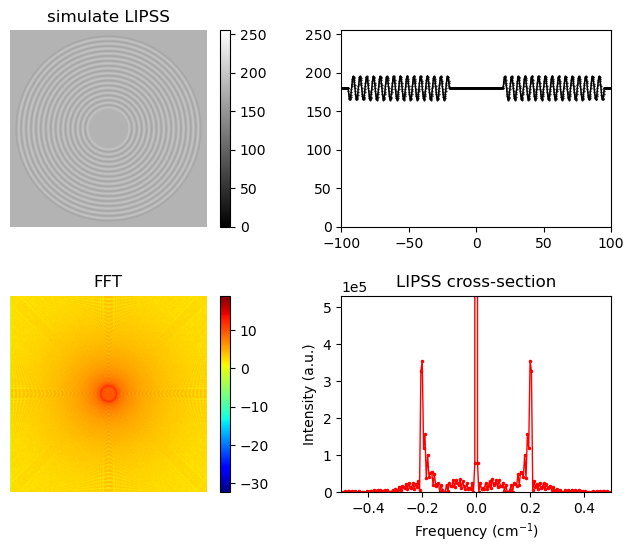

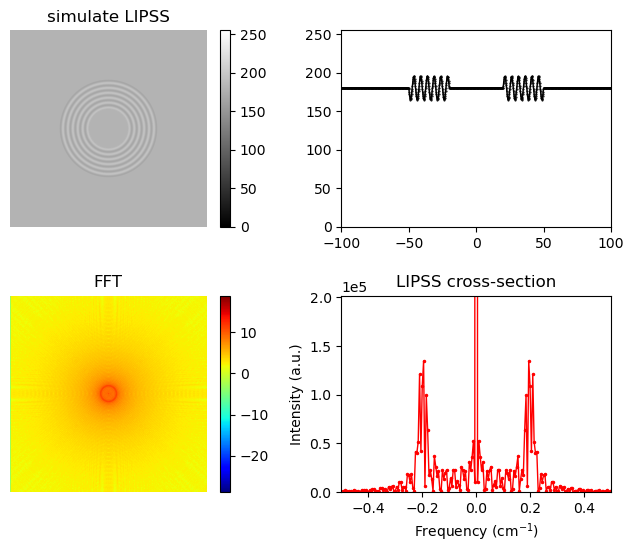

In [7]:
def plt_simulateDonet(A, y0, delta_y, k, phi, r1, r2, randomRange):
    
    
    x, r, N, simulateRange = simulateArray(1000, 100)
    simulate_function      = LIPSS.SimulateLIPSS(A, y0, delta_y, k, phi, r1, r2)
    ZZ = simulate_function.simulateDonet(r) + noice(row=N, col=N, randomRange=randomRange)
    
    # FFT
    fftClass = FFTfunc.FFT('noFile')
    twoD_FFT = fftClass.array2FFT(ZZ)
    twoD_FFT_log = np.log(twoD_FFT)
    
    length, width = twoD_FFT.shape
    fft_width_pixel = FFTfunc.FFT('nothing').FFTAxisCenterbeZero(width)
    fft_length_pixel  = FFTfunc.FFT('nothing').FFTAxisCenterbeZero(length)

    # --- colorbar change scale --- #
    fftBackage = findBackage(twoD_FFT_log)
    vmin = 19 - (1150/383)*(19-fftBackage)
    
    fig = plt.figure(figsize=(8, 6), dpi=100)
    fig.subplots_adjust(hspace = .35, wspace = .3)
    
    ax1 = fig.add_subplot(221)
    im = ax1.imshow(ZZ, cmap='gray', vmin = 0, vmax = 255) 
    cbar = plt.colorbar(im, ax=ax1)
    ax1.set_title('simulate LIPSS')
    plt.axis('off')
    
    ax2 = fig.add_subplot(222)
    ax2.plot(x, ZZ[length//2], 'k.-',markersize = 1, linewidth = 1)
    ax2.set_xlim(-100, 100)
    # # ax3.set_xlim(50, 100) # room in 
    ax2.set_ylim(0, 255)
    # ax2.set_title('LIPSS cross-section')
    # ax2.set_ylabel('Profile') 
    # ax2.set_xlabel('Distance (cm)')
    
    ax3 = fig.add_subplot(223)
    im2 = ax3.imshow(twoD_FFT_log, extent=fftClass.extent(length, width), cmap='jet', vmin=vmin, vmax=19) 
    cbar2 = plt.colorbar(im2, ax=ax3)
    # ax3.set_xlim(-50, 50)
    # ax3.set_ylim(-50, 50)
    ax3.set_title('FFT')
    plt.axis('off')

    ax4 = fig.add_subplot(224)
    # # --- 轉換成空間頻率 --- #
    fft_inverseSpace =  fft_width_pixel / (simulateRange*2) # 整張圖大小為 simulateRange*2
    fft_inverseSpace = np.round(fft_inverseSpace, 3)
    ax4.set_xlim(-.5, .5)
    ax4.plot(fft_inverseSpace, twoD_FFT[width//2], 'r.-',markersize = 3, linewidth = 1)
    second_largest = findSecondPeak(data=twoD_FFT[length//2], second='Yes')
    ax4.set_ylim(0, second_largest*1.5)
    ax4.ticklabel_format(style='sci', scilimits=(-1,2), axis='y')  # 科學記號
    ax4.set_title('LIPSS cross-section')
    ax4.set_ylabel('Intensity (a.u.)')
    ax4.set_xlabel('Frequency (cm$^{-1}$)') 

plt_simulateDonet(A=15, y0=180, delta_y=0, k=0.2, phi=0, r1=20, r2=95, randomRange=0)
plt_simulateDonet(A=15, y0=180, delta_y=0, k=0.2, phi=0, r1=20, r2=50, randomRange=0)
# plt_simulateDonet(A=20, y0=180, delta_y=0,  k=0.3, phi=0, r1=20, r2=80, randomRange=20)
# plt_simulateDonet(A=20, y0=160, delta_y=60, k=0.3, phi=0, r1=20, r2=80, randomRange=20)
# plt_simulateDonet(A=30, y0=180, delta_y=0, k=0.2, phi=0, r1=20, r2=80, randomRange=50)

In [8]:
onedrivePath = '/Users/k.y.chen/Library/CloudStorage/OneDrive-國立陽明交通大學/文件/交大電物/實驗室/7. 實驗 Data/'

### 2.  SEM analisis

#### 2.1 SEM imshow

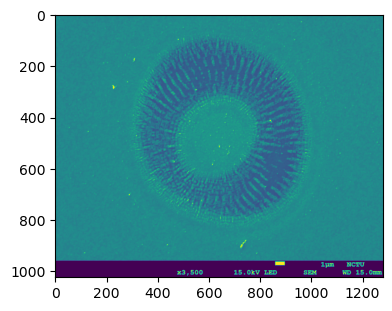

In [32]:
def plt_SEM_imshow(file_path, center, length):
    scalebar = caculate_scaleBar(onedrivePath + f'20230413 SEM/AP/18.tif', pltphoto=None)
    
    fftClass = FFTfunc.FFT(file_path)
    im_array = fftClass.image2Array()
    # 裁減 array 
    cropped_array = fftClass.arrayCutSquare(array=im_array, center=center, length=length)
    # FFT
    twoD_FFT = fftClass.array2FFT(cropped_array)
    length, width = twoD_FFT.shape
    # 長寬的導空間 (pixel)
    fft_length_pixel, fft_width_pixel = FFTfunc.FFT('noFile').FFTAxisCenterbeZero(length), FFTfunc.FFT('noFile').FFTAxisCenterbeZero(width)
    # 長寬的導空間 (wavenumber)
    fft_inverseSpace = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_width_wavenumber  = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_length_wavenumber = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=length , scale_bar=scalebar)
    
   # 設置圖片範圍和邊界
    extent = [0, scalebar*cropped_array.shape[1], 0, scalebar*cropped_array.shape[0]]
    
    fig  = plt.figure(figsize=(10, 8), dpi=100)
    fig.subplots_adjust(hspace = .35, wspace = .3)
    ax1  = fig.add_subplot(221)
    real_y, real_x = fftClass.realSpaceAxis(cropped_array, scalebar)
    ax1.imshow(im_array)
    # im   = ax1.imshow(cropped_array, cmap='gray', vmin=0, vmax=255, extent=extent)
    # cbar = plt.colorbar(im, ax=ax1)
    # ax1.set_title('RP OM image')
    # ax1.set_xlabel('unit: $\mathrm{\mu m}$') 
    # # ---- FFT image --- #
    # ax2  = fig.add_subplot(222)
    # im2  = ax2.imshow(np.log(twoD_FFT), cmap='jet', vmin=-9, vmax=18, extent=fftClass.extent4FFT(width, length), aspect=1)
    # ax2.locator_params(axis ='both', nbins = 7)     
    # cbar2 = plt.colorbar(im2, ax=ax2)
    # fftlim = 100
    # ax2.set_xlim(-fftlim, fftlim)
    # ax2.set_ylim(-fftlim, fftlim)
    # cbar2.locator = plt_ticker.MaxNLocator(nbins= 1)
    # ax2.set_title('FFT')
    # # ax2.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    # # ax2.set_xlabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    # plt.show()


plt_SEM_imshow(onedrivePath + f'20230413 SEM/AP/18.tif', center=(.45, .5), length=.375)

#### 2.2 SEM contourf

In [10]:
def plt_SEM_contourf(file_path, top, bottom, left, right):
    scalebar = caculate_scaleBar(onedrivePath + f'20230214 SEM/68.tif', pltphoto=None)
    
    fftClass = FFTfunc.FFT(file_path)
    im_array = fftClass.image2Array()
    # 裁減 array 
    cropped_array = fftClass.arrayCut(array=im_array, top=top, bottom=bottom, left=left, right=right)
    # FFT
    twoD_FFT = fftClass.array2FFT(cropped_array)
    length, width = twoD_FFT.shape
    # 長寬的導空間 (pixel)
    fft_length_pixel, fft_width_pixel = FFTfunc.FFT('noFile').FFTAxisCenterbeZero(length), FFTfunc.FFT('noFile').FFTAxisCenterbeZero(width)
    # 長寬的導空間 (wavenumber)
    fft_inverseSpace = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_width_wavenumber  = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_length_wavenumber = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=length , scale_bar=scalebar)
    
    
    fig  = plt.figure(figsize=(10, 8), dpi=100)
    fig.subplots_adjust(hspace = .35, wspace = .3)
    ax1  = fig.add_subplot(221)
    real_y, real_x = fftClass.realSpaceAxis(cropped_array, scalebar)
    # im   = ax1.imshow(cropped_array, cmap='gray', vmin=0, vmax=255)
    im   = ax1.contourf(real_x, real_y, cropped_array, 10, cmap='gray', vmin=0, vmax=255)
    cbar = plt.colorbar(im, ax=ax1)
    ax1.set_title('RP SEM image')
    # ax1.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    ax1.set_xlabel('unit: $\mathrm{\mu m}$') 
    # plt.axis('off')
    # ---- FFT image --- #
    ax2  = fig.add_subplot(222)
    im2  = ax2.contourf(fft_width_wavenumber, fft_length_wavenumber, np.log(twoD_FFT), 100, cmap="jet", vmin=-9, vmax=18)
    ax2.locator_params(axis ='both', nbins = 11)     
    ax2.set_xlim(-2, 2)
    ax2.set_ylim(-2, 2)
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.locator = plt_ticker.MaxNLocator(nbins= 1) 
    ax2.set_title('FFT')
    ax2.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    ax2.set_xlabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 

# plt_SEM_contourf(onedrivePath + f'20230214 SEM/74.tif', 0.15, 0.77, 0.26, 0.75)

#### 2.3 SEM analisis 新版本 (嘗試中)

      --- 選定中心裁切 ----

In [11]:
def plt_SEM(file_path, center, length):
    scalebar = caculate_scaleBar(onedrivePath + f'20230413 SEM/AP/18.tif', pltphoto=None)
    
    fftClass = FFTfunc.FFT(file_path)
    im_array = fftClass.image2Array()
    # 裁減 array 
    cropped_array = fftClass.arrayCutSquare(array=im_array, center=center, length=length)
    # FFT
    twoD_FFT = fftClass.array2FFT(cropped_array)
    length, width = twoD_FFT.shape
    # 長寬的導空間 (pixel)
    fft_length_pixel, fft_width_pixel = FFTfunc.FFT('noFile').FFTAxisCenterbeZero(length), FFTfunc.FFT('noFile').FFTAxisCenterbeZero(width)
    # 長寬的導空間 (wavenumber)
    fft_inverseSpace = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_width_wavenumber  = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_length_wavenumber = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=length , scale_bar=scalebar)
    
    
    fig  = plt.figure(figsize=(10, 8), dpi=100)
    fig.subplots_adjust(hspace = .35, wspace = .3)
    ax1  = fig.add_subplot(221)
    real_y, real_x = fftClass.realSpaceAxis(cropped_array, scalebar)
    # im   = ax1.imshow(cropped_array, cmap='gray', vmin=0, vmax=255)
    im   = ax1.contourf(real_x, real_y, cropped_array, 10, cmap='gray', vmin=0, vmax=255)
    cbar = plt.colorbar(im, ax=ax1)
    ax1.set_title('RP SEM image')
    ax1.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    ax1.set_xlabel('unit: $\mathrm{\mu m}$') 
    plt.axis('off')
    # ---- FFT image --- #
    ax2  = fig.add_subplot(222)
    im2  = ax2.contourf(fft_width_wavenumber, fft_length_wavenumber, np.log(twoD_FFT), 100, cmap="jet", vmin=-9, vmax=18)
    ax2.locator_params(axis ='both', nbins = 11)     
    # fft_lim = 5
    # ax2.set_xlim(-fft_lim, fft_lim)
    # ax2.set_ylim(-fft_lim, fft_lim)
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.locator = plt_ticker.MaxNLocator(nbins= 1) 
    ax2.set_title('FFT')
    ax2.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    ax2.set_xlabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 

# plt_SEM(onedrivePath + f'20230413 SEM/AP/18.tif', center=(.5, .5), length=.3)

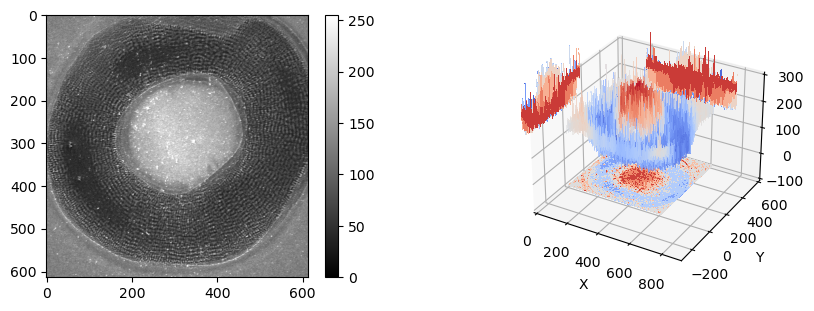

In [12]:
def testDonet3D(file_path, center, length):
    scalebar = caculate_scaleBar(onedrivePath + f'20230214 SEM/68.tif', pltphoto=None)
    
    fftClass = FFTfunc.FFT(file_path)
    im_array = fftClass.image2Array()
    cropped_array = fftClass.arrayCutSquare(array=im_array, center=center, length=length)
    XXX, YYY = cropped_array.shape
    X, Y = np.linspace(0, XXX-1, XXX), np.linspace(0, YYY-1, YYY)
    X, Y = np.meshgrid(X, Y)
    fig  = plt.figure(figsize=(10, 8), dpi=100)
    fig.subplots_adjust(hspace = .35, wspace = .3)
    ax1  = fig.add_subplot(221)
    real_y, real_x = fftClass.realSpaceAxis(cropped_array, scalebar)
    im   = ax1.imshow(cropped_array, cmap='gray', vmin=0, vmax=255)
    # im   = ax1.contourf(real_x, real_y, cropped_array, 10, cmap='gray', vmin=0, vmax=255)
    cbar = plt.colorbar(im, ax=ax1)

    ax2 = fig.add_subplot(222, projection='3d')
    # ax2.plot_surface(real_x, real_y, cropped_array, cmap='coolwarm')
    ax2.plot_surface(X, Y, cropped_array, cmap=plt.cm.coolwarm, alpha=0.5, antialiased=False)
    
    cset = ax2.contourf(X, Y, cropped_array, zdir='z', offset=-100, cmap=plt.cm.coolwarm)
    cset = ax2.contourf(X, Y, cropped_array, zdir='x', offset=-300, cmap=plt.cm.coolwarm)
    cset = ax2.contourf(X, Y, cropped_array, zdir='y', offset=900, cmap=plt.cm.coolwarm)

    ax2.set_xlim(0, 900)
    ax2.set_ylim(-300, 600)
    ax2.set_zlim(-100, 300)

    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_zlabel('Z')

testDonet3D(onedrivePath + f'20230214 SEM/74.tif', center=(.5, .5), length=.3)

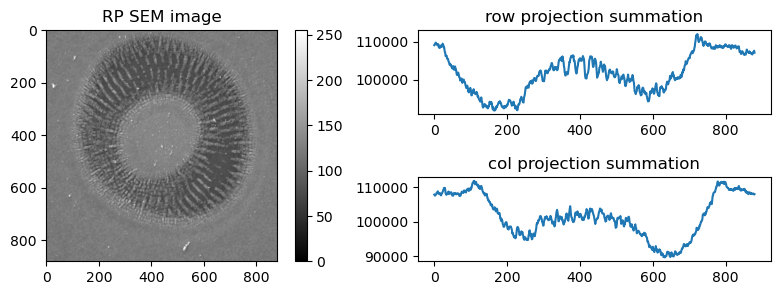

In [36]:
def SEMDonetCut(file_path, center, length):
    scalebar = caculate_scaleBar(onedrivePath + f'20230214 SEM/68.tif', pltphoto=None)
    
    fftClass = FFTfunc.FFT(file_path)
    im_array = fftClass.image2Array()
    # 裁減 array 
    cropped_array = fftClass.arrayCutSquare(array=im_array, center=center, length=length)
    # FFT
    twoD_FFT = fftClass.array2FFT(cropped_array)
    length, width = twoD_FFT.shape
    # 長寬的導空間 (pixel)
    fft_length_pixel, fft_width_pixel = FFTfunc.FFT('noFile').FFTAxisCenterbeZero(length), FFTfunc.FFT('noFile').FFTAxisCenterbeZero(width)
    # 長寬的導空間 (wavenumber)
    fft_inverseSpace = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_width_wavenumber  = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_length_wavenumber = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=length , scale_bar=scalebar)
    
    
    fig  = plt.figure(figsize=(10, 3), dpi=100)
    fig.subplots_adjust(hspace = .75, wspace = .2)
    ax1  = fig.add_subplot(121)
    real_y, real_x = fftClass.realSpaceAxis(cropped_array, scalebar)
    im   = ax1.imshow(cropped_array, cmap='gray', vmin=0, vmax=255)
    cbar = plt.colorbar(im, ax=ax1)
    ax1.set_title('RP SEM image')
    # 对每一行进行求和操作，指定axis=1表示沿着第二个维度（即每行）求和
    sum_x = np.sum(cropped_array, axis=1)
    # 对每一列进行求和操作，指定axis=0表示沿着第一个维度（即每列）求和
    sum_y = np.sum(cropped_array, axis=0)
    ax2 = fig.add_subplot(222)
    ax2.plot(sum_x)
    ax2.set_title('row projection summation')
    ax4 = fig.add_subplot(224)
    ax4.plot(sum_y)
    ax4.set_title('col projection summation')

SEMDonetCut(onedrivePath + f'20230413 SEM/AP/18.tif', center=(.5, .5), length=.43)
# SEMDonetCut(onedrivePath + f'20230413 SEM/AP/18.tif', center=(.47, .51), length=.33)

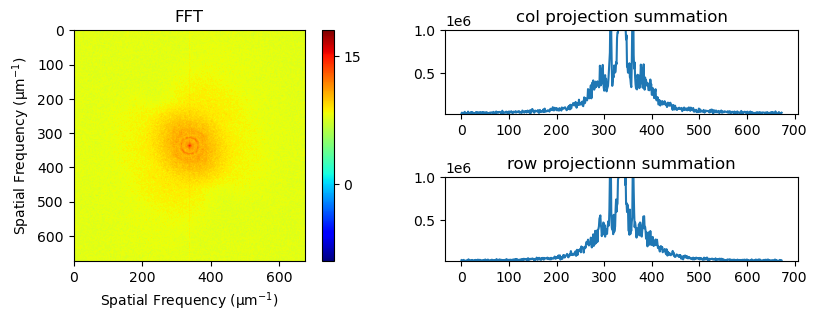

In [14]:
def FFTDonetCut(file_path, center, length, center2, length2):
    scalebar = caculate_scaleBar(onedrivePath + f'20230214 SEM/68.tif', pltphoto=None)
    
    fftClass = FFTfunc.FFT(file_path)
    im_array = fftClass.image2Array()
    # 裁減 array 
    cropped_array = fftClass.arrayCutSquare(array=im_array, center=center, length=length)
    # FFT
    twoD_FFT = fftClass.array2FFT(cropped_array)
    # twoD_FFT = fftClass.arrayCutSquare(array=twoD_FFT, center=center2, length=length2)
    length, width = twoD_FFT.shape
    # 長寬的導空間 (pixel)
    fft_length_pixel, fft_width_pixel = FFTfunc.FFT('noFile').FFTAxisCenterbeZero(length), FFTfunc.FFT('noFile').FFTAxisCenterbeZero(width)
    # 長寬的導空間 (wavenumber)
    fft_inverseSpace = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_width_wavenumber  = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_length_wavenumber = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=length , scale_bar=scalebar)
    
    
    fig  = plt.figure(figsize=(10, 3), dpi=100)
    fig.subplots_adjust(hspace = .75, wspace = .2)
        # ---- FFT image --- #
    ax2  = fig.add_subplot(121)
    im2  = ax2.imshow(np.log(twoD_FFT), cmap="jet", vmin=-9, vmax=18)
    # fft_lim = 5
    # ax2.set_xlim(-fft_lim, fft_lim)
    # ax2.set_ylim(-fft_lim, fft_lim)
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.locator = plt_ticker.MaxNLocator(nbins= 1) 
    ax2.set_title('FFT')
    ax2.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    ax2.set_xlabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    
    # 对每一行进行求和操作，指定axis=1表示沿着第二个维度（即每行）求和
    sum_x = np.sum(twoD_FFT[:, length//2-5:length//2+5], axis=1)
    # # 对每一列进行求和操作，指定axis=0表示沿着第一个维度（即每列）求和
    sum_y = np.sum(twoD_FFT[length//2-5:length//2+5, :], axis=0)
    ax3 = fig.add_subplot(222)
    ax3.plot(sum_x)
    ax3.set_ylim(min(sum_x), 1e6)
    ax3.set_title('col projection summation')
    ax4 = fig.add_subplot(224)
    ax4.plot(sum_y)
    ax4.set_ylim(min(sum_x), 1e6)
    ax4.set_title('row projectionn summation')
    
    peaks, _ = find_peaks(sum_x[400:450])


FFTDonetCut(onedrivePath + f'20230413 SEM/AP/18.tif', center=(.47, .51), length=.33, center2=(.5, .5), length2=.49)

#### gaussian fit spatial frequency

###### - 目的： 用 5 個 gaussian fit 空間頻率
###### - 結果： 大失敗


In [15]:
def gaussian(x, a, x0, sigma):
        return abs(a) * np.exp(-(x - x0)**2 / (2 * sigma**2))

def multi_gaussian(x, *params):
    n_gaussians = len(params) // 3
    result = np.zeros_like(x)
    for i in range(n_gaussians):
        a = params[i*3]
        x0 = params[i*3 + 1]
        sigma = params[i*3 + 2]
        result += gaussian(x, a, x0, sigma)
    return result

def fitMultiGaussian(xdat, ydat, guess):
    
    p0 = np.array(guess)
    popt, pcov = curve_fit(multi_gaussian, xdat, ydat, p0=p0)

    # 將參數轉換成 DataFrame
    df_params = pd.DataFrame(popt.reshape(-1, 3), columns=['A', 'x0', 'sigma'])
    df_params.index.name = 'Gaussian'
    print(df_params)

    # 繪製結果
    fig = plt.figure(figsize=(5, 3), dpi=100)
    ax1 = fig.add_subplot(111)
    
    # ax1.plot(xdat, ydat, 'b-', label='data')
    ax1.bar(xdat, ydat, width=1.3, color = 'wheat')
    
    # ax1.plot(xdat, multi_gaussian(xdat, *popt), color='lime', lw=2, label='model', linestyle="-")     
    a = df_params
    ax1.plot(xdat, gaussian(xdat, a.iloc[0,0], a.iloc[0,1], a.iloc[0,2]), 'tomato',     label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[1,0], a.iloc[1,1], a.iloc[1,2]), 'mediumblue', label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[2,0], a.iloc[2,1], a.iloc[2,2]), 'fuchsia',    label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[3,0], a.iloc[3,1], a.iloc[3,2]), 'red',        label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[4,0], a.iloc[4,1], a.iloc[4,2]), 'k',        label='s', lw=1, linestyle="--")
    
    ax1.plot(xdat, gaussian(xdat, a.iloc[0,0], a.iloc[0,1], a.iloc[0,2]), 'tomato',     label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[1,0], a.iloc[1,1], a.iloc[1,2]), 'mediumblue', label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[2,0], a.iloc[2,1], a.iloc[2,2]), 'fuchsia',    label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[3,0], a.iloc[3,1], a.iloc[3,2]), 'red',        label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[4,0], a.iloc[4,1], a.iloc[4,2]), 'k',        label='s', lw=1, linestyle="--")
    ax1.set_ylim(min(ydat), findSecondPeak(ydat))

def testDonet3D(file_path, center, length, center2, length2, guess):
    scalebar = caculate_scaleBar(onedrivePath + f'20230214 SEM/68.tif', pltphoto=None)
    
    fftClass = FFTfunc.FFT(file_path)
    im_array = fftClass.image2Array()
    # 裁減 array 
    cropped_array = fftClass.arrayCutSquare(array=im_array, center=center, length=length)
    # FFT
    twoD_FFT = fftClass.array2FFT(cropped_array)
    # twoD_FFT = fftClass.arrayCutSquare(array=twoD_FFT, center=center2, length=length2)
    length, width = twoD_FFT.shape
    # 長寬的導空間 (pixel)
    fft_length_pixel, fft_width_pixel = FFTfunc.FFT('noFile').FFTAxisCenterbeZero(length), FFTfunc.FFT('noFile').FFTAxisCenterbeZero(width)
    # 長寬的導空間 (wavenumber)
    fft_inverseSpace = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_width_wavenumber  = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_length_wavenumber = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=length , scale_bar=scalebar)
    
    
    fig  = plt.figure(figsize=(10, 3), dpi=100)
    
    # 对每一行进行求和操作，指定axis=1表示沿着第二个维度（即每行）求和
    sum_x = np.sum(twoD_FFT[:, length//2-5:length//2+5], axis=1)
    # # 对每一列进行求和操作，指定axis=0表示沿着第一个维度（即每列）求和
    sum_y = np.sum(twoD_FFT[length//2-5:length//2+5, :], axis=0)
    ax3 = fig.add_subplot(222)
    ax3.plot(sum_x)
    ax3.set_ylim(min(sum_x), 1e6)
    ax3.set_title('col projection summation')

    x = np.linspace(0, len(sum_x)-1, len(sum_x))
    fitMultiGaussian(x, sum_x, guess)



#### 2.4. for OM image

In [16]:
def plt_OM(file_path, top, bottom, left, right):
    scalebar = caculate_OMscalebar(onedrivePath + 'photo/2023.03.20/RP room in/2500 n4 3-1_ leftup.jpg', 0.93, .97, 0.75, 1)
    
    fftClass = FFTfunc.FFT(file_path)
    im_array = fftClass.image2Array()
    # 裁減 array 
    cropped_array = fftClass.arrayCut(array=im_array, top=top, bottom=bottom, left=left, right=right)
    # FFT
    twoD_FFT = fftClass.array2FFT(cropped_array)
    length, width = twoD_FFT.shape
    # 長寬的導空間 (pixel)
    fft_length_pixel, fft_width_pixel = FFTfunc.FFT('noFile').FFTAxisCenterbeZero(length), FFTfunc.FFT('noFile').FFTAxisCenterbeZero(width)
    # 長寬的導空間 (wavenumber)
    fft_inverseSpace = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_width_wavenumber  = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_length_wavenumber = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=length , scale_bar=scalebar)
    
    
    fig  = plt.figure(figsize=(10, 8), dpi=100)
    fig.subplots_adjust(hspace = .35, wspace = .3)
    ax1  = fig.add_subplot(221)
    real_y, real_x = fftClass.realSpaceAxis(cropped_array, scalebar)
    # im   = ax1.imshow(cropped_array, cmap='gray', vmin=0, vmax=255)
    im   = ax1.contourf(real_x, real_y, cropped_array, 100, cmap='gray', vmin=0, vmax=255)
    cbar = plt.colorbar(im, ax=ax1)
    ax1.set_title('RP OM image')
    # ax1.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    ax1.set_xlabel('unit: $\mathrm{\mu m}$') 
    # plt.axis('off')
    # ---- FFT image --- #
    ax2  = fig.add_subplot(222)
    im2  = ax2.contourf(fft_width_wavenumber, fft_length_wavenumber, np.log(twoD_FFT), 20, cmap="jet", vmin=-9, vmax=18)
    ax2.locator_params(axis ='both', nbins = 7)     
    cbar2 = plt.colorbar(im2, ax=ax2)
    fftlim = .05
    ax2.set_xlim(-fftlim, fftlim)
    ax2.set_ylim(-fftlim, fftlim)
    cbar2.locator = plt_ticker.MaxNLocator(nbins= 1)
    ax2.set_title('FFT')
    ax2.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    ax2.set_xlabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 

# plt_OM(onedrivePath +'photo/2023.03.20/RP room in/2500 n4 3-1_ leftup.jpg', 0, .4, 0.15, .5)
# plt_OM(onedrivePath +'photo/2023.03.20/AP room in/1350 n4 4-1.jpg', 0.05, .45, 0.15, .45)

#### test in imshow

614 718


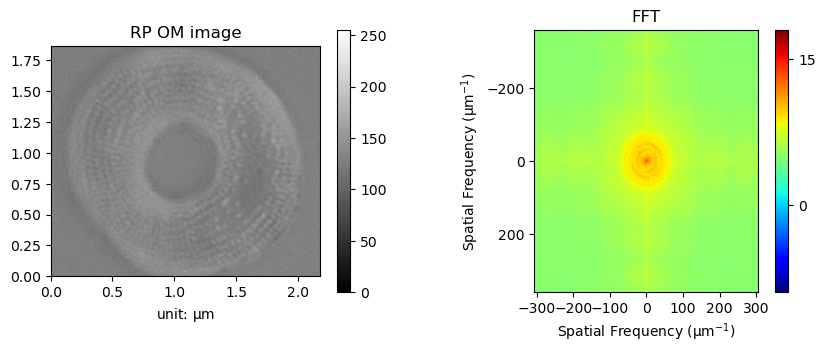

In [17]:
def plt_OM_test(file_path, top, bottom, left, right):
    scalebar = caculate_OMscalebar(onedrivePath + 'photo/2023.03.20/RP room in/2500 n4 3-1_ leftup.jpg', 0.93, .97, 0.75, 1)
    
    fftClass = FFTfunc.FFT(file_path)
    im_array = fftClass.image2Array()
    # 裁減 array 
    cropped_array = fftClass.arrayCut(array=im_array, top=top, bottom=bottom, left=left, right=right)
    # FFT
    twoD_FFT = fftClass.array2FFT(cropped_array)

    length, width = twoD_FFT.shape
    # 長寬的導空間 (pixel)
    fft_length_pixel, fft_width_pixel = FFTfunc.FFT('noFile').FFTAxisCenterbeZero(length), FFTfunc.FFT('noFile').FFTAxisCenterbeZero(width)
    # 長寬的導空間 (wavenumber)
    fft_inverseSpace = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_width_wavenumber  = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_length_wavenumber = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=length , scale_bar=scalebar)
    
    # 設置圖片範圍和邊界
    extent = [0, scalebar*cropped_array.shape[1], 0, scalebar*cropped_array.shape[0]]
    
    fig  = plt.figure(figsize=(10, 8), dpi=100)
    fig.subplots_adjust(hspace = .35, wspace = .3)
    ax1  = fig.add_subplot(221)
    real_y, real_x = fftClass.realSpaceAxis(cropped_array, scalebar)
    im   = ax1.imshow(cropped_array, cmap='gray', vmin=0, vmax=255, extent=extent)
    cbar = plt.colorbar(im, ax=ax1)
    ax1.set_title('RP OM image')
    ax1.set_xlabel('unit: $\mathrm{\mu m}$') 
    # ---- FFT image --- #
    
    
    ax2  = fig.add_subplot(222)
    im2  = ax2.imshow(np.log(twoD_FFT), cmap='jet', vmin=-9, vmax=18, extent=fftClass.extent4FFT(width, length), aspect=1)
    ax2.locator_params(axis ='both', nbins = 7)     
    cbar2 = plt.colorbar(im2, ax=ax2)
    fftlim = 3
    # ax2.set_xlim(-fftlim, fftlim)
    # ax2.set_ylim(-fftlim, fftlim)

    cbar2.locator = plt_ticker.MaxNLocator(nbins= 1)
    ax2.set_title('FFT')
    ax2.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    ax2.set_xlabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    print(length, width)
    

    
plt_OM_test(onedrivePath +'photo/2023.03.20/RP room in/2500 n4 3-1_ leftup.jpg', 0, .4, 0.15, .5)

#### 2.5. 裁切局部區域

In [18]:
def plt_cutIm(file_path, top, bottom, left, right, t, b, l, r):
    scalebar = caculate_scaleBar(onedrivePath + f'20230214 SEM/68.tif')
    
    fftClass = FFTfunc.FFT(file_path)
    im_array = fftClass.image2Array()
    # 裁減 array 
    cropped_array = fftClass.arrayCut(array=im_array, top=top, bottom=bottom, left=left, right=right)
    cropped_array = fftClass.arrayCut(cropped_array, t, b, l, r)
    # FFT
    twoD_FFT = fftClass.array2FFT(cropped_array)
    length, width = twoD_FFT.shape
    # 長寬的導空間 (pixel)
    fft_length_pixel, fft_width_pixel = FFTfunc.FFT('noFile').FFTAxisCenterbeZero(length), FFTfunc.FFT('noFile').FFTAxisCenterbeZero(width)
    # 長寬的導空間 (wavenumber)
    fft_inverseSpace = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_width_wavenumber  = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=width, scale_bar=scalebar)
    fft_length_wavenumber = fftClass.pixel_2_InverseSpaceAxis(num_of_realSpaceShape=length , scale_bar=scalebar)
    
    # print(fft_length_wavenumber)
    fig  = plt.figure(figsize=(10, 8), dpi=100)
    fig.subplots_adjust(hspace = .35, wspace = .3)
    ax1  = fig.add_subplot(221)
    real_y, real_x = fftClass.realSpaceAxis(cropped_array, scalebar)
    # im   = ax1.imshow(cropped_array, cmap='gray', vmin=0, vmax=255)
    im   = ax1.contourf(real_x, real_y, cropped_array, 100, cmap='gray', vmin=0, vmax=255)
    cbar = plt.colorbar(im, ax=ax1)
    ax1.set_title('RP SEM image')
    # ax1.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    # ax1.set_xlabel('unit: $\mathrm{\mu m}$') 
    # plt.axis('off')
    # ---- FFT image --- #
    ax2  = fig.add_subplot(222)
    im2  = ax2.contourf(fft_width_wavenumber, fft_length_wavenumber, np.log(twoD_FFT), 100, cmap="jet", vmin=-9, vmax=18)
    # im2  = ax2.imshow(np.log(twoD_FFT), cmap="jet", vmin=-9, vmax=18)
    ax2.locator_params(axis ='both', nbins = 11)   
    fft_range = 5
    ax2.set_xlim(-fft_range, fft_range)
    ax2.set_ylim(-fft_range, fft_range)
    cbar2 = plt.colorbar(im2, ax=ax2)
    cbar2.locator = plt_ticker.MaxNLocator(nbins= 1) 
    ax2.set_title('FFT')
    ax2.set_ylabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    ax2.set_xlabel('Spatial Frequency ($\mathrm{\mu m}^{-1}$)') 
    

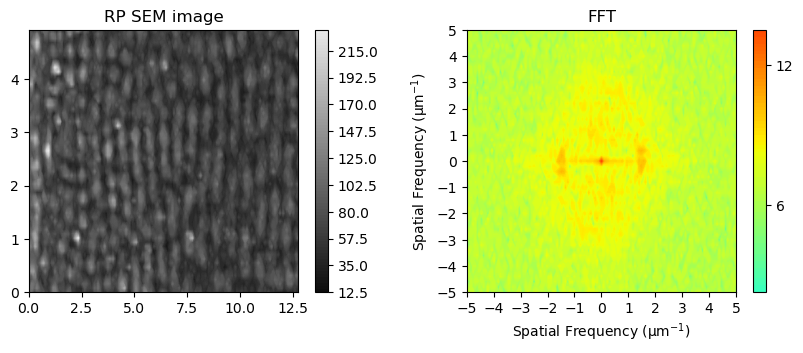

In [19]:
plt_cutIm(onedrivePath + f'20230214 SEM/74.tif', 0.15, 0.77, 0.26, 0.75, 
                                                 0.45, 0.55, 0.74, 1)

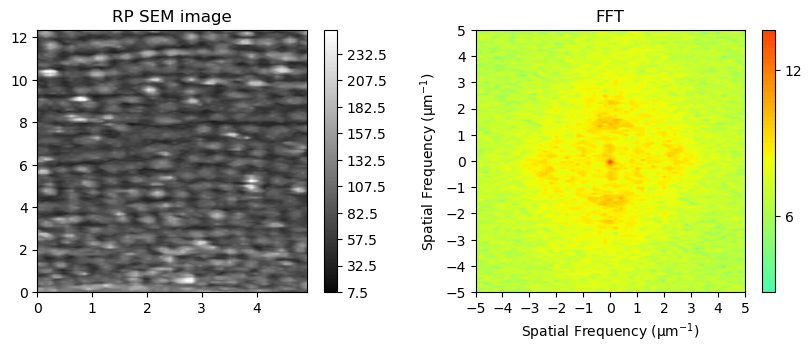

In [20]:
plt_cutIm(onedrivePath + f'20230214 SEM/74.tif', 0.15, 0.77, 0.26, 0.75, 
                                                 0.74, 0.99, 0.45, 0.55)

## test zone

In [37]:
def gaussian(x, a, x0, sigma):
        return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

def multi_gaussian(x, *params):
    n_gaussians = len(params) // 3
    result = np.zeros_like(x)
    for i in range(n_gaussians):
        a = params[i*3]
        x0 = params[i*3 + 1]
        sigma = params[i*3 + 2]
        result += gaussian(x, a, x0, sigma)
    return result

def fitMultiGaussian(xdat, ydat, guess):
    
    p0 = np.array(guess)
    popt, pcov = curve_fit(multi_gaussian, xdat, ydat, p0=p0)

    # 將參數轉換成 DataFrame
    df_params = pd.DataFrame(popt.reshape(-1, 3), columns=['A', 'x0', 'sigma'])
    df_params.index.name = 'Gaussian'
    print(df_params)

    # 繪製結果
    fig = plt.figure(figsize=(5, 3), dpi=100)
    ax1 = fig.add_subplot(111)
    
    # ax1.plot(xdat, ydat, 'b-', label='data')
    ax1.bar(xdat, ydat, width=.01, color = 'wheat') 
    ax1.plot(xdat, multi_gaussian(xdat, *popt), color='lime', lw=2, label='model', linestyle="-")     
    a = df_params
    ax1.plot(xdat, gaussian(xdat, a.iloc[0,0], a.iloc[0,1], a.iloc[0,2]), 'tomato',     label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[1,0], a.iloc[1,1], a.iloc[1,2]), 'mediumblue', label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[2,0], a.iloc[2,1], a.iloc[2,2]), 'fuchsia',    label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[3,0], a.iloc[3,1], a.iloc[3,2]), 'red',        label='s', lw=1, linestyle="--")
    ax1.plot(xdat, gaussian(xdat, a.iloc[4,0], a.iloc[4,1], a.iloc[4,2]), 'red',        label='s', lw=1, linestyle="--")
    ax1.set_ylim(min(ydat), findSecondPeak(ydat))
    
def test(guess):
    
    # 生成一組假數據
    x = np.linspace(-5, 5, 1000)
    y_true = (gaussian(x, 1, -2, 0.5) + gaussian(x, 0.5, 1, 1) + gaussian(x, 0.3, 3, 0.3) + 
              gaussian(x, 0.2, -1, 1.5) + gaussian(x, 0.1, 4, 0.8))
    y_meas = y_true + 0.02 * np.random.normal(size=len(x))
    
    fitMultiGaussian(x, y_meas, guess)


# test([1  , -2 , 0.5, 
#       0.5, 1  , 1, 
#       0.3, 3  , 0.3, 
#       0.2, -1 , 1.5, 
#       0.1, 4  , 0.8])